In [9]:
import os
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"

In [10]:
sc.stop()

In [11]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext


conf = SparkConf().setAppName("Spark-Logs-Handling").setMaster("local[*]")
sc = SparkContext.getOrCreate(conf)

sqlcontext = SQLContext(sc)
rdd = sc.textFile("file:///home//hadoop/Downloads/access_log_Jul95")
rdd.count()

1891715

In [12]:
rdd.take(5)

['199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245',
 'unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985',
 '199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085',
 'burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0',
 '199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179']

#### Get IP address/host name

This regex is at the start of the log and includes any non-white characted

In [13]:
import re
rslt=(rdd.map(lambda line: re.search('\S+',line).group(0)).take(4)) # Get the IP address \host name
rslt

['199.72.81.55',
 'unicomp6.unicomp.net',
 '199.120.110.21',
 'burger.letters.com']

#### Get Timestamp

In [14]:
rslt=(rdd.map(lambda line: re.search('(\S+ -\d{4})',line)
    .groups())
    .take(3))  #Get the  date
rslt

[('[01/Jul/1995:00:00:01 -0400',),
 ('[01/Jul/1995:00:00:06 -0400',),
 ('[01/Jul/1995:00:00:09 -0400',)]

#### HTTP request

Get the HTTP request sent to Web server \w+ {GET}

In [15]:
# Get the REST call with " "
rslt=(rdd.map(lambda line: re.search('"\w+\s+([^\s]+)\s+HTTP.*"',line)
    .groups())
    .take(3)) # Get the REST call
rslt

[('/history/apollo/',),
 ('/shuttle/countdown/',),
 ('/shuttle/missions/sts-73/mission-sts-73.html',)]

#### Get HTTP Response status

Get the HTTP response to the request

In [16]:
rslt=(rdd.map(lambda line: re.search('"\s(\d{3})',line)
    .groups())
    .take(3)) #Get the status
rslt

[('200',), ('200',), ('200',)]

### Get content size
Get the HTTP response in bytes

In [17]:
rslt=(rdd.map(lambda line: re.search('^.*\s(\d*)$',line).groups()).take(3)) # Get the content size
rslt

[('6245',), ('3985',), ('4085',)]

Putting it all together
Now put all the individual pieces together into 1 big regular expression and assign to the groups

1. Host 2. Timestamp 3. Path 4. Status 5. Content_size

In [18]:
rslt=(rdd.map(lambda line: re.search('^(\S+)((\s)(-))+\s(\[\S+ -\d{4}\])\s("\w+\s+([^\s]+)\s+HTTP.*")\s(\d{3}\s(\d*)$)',line)
    .groups())
    .take(3))
rslt

[('199.72.81.55',
  ' -',
  ' ',
  '-',
  '[01/Jul/1995:00:00:01 -0400]',
  '"GET /history/apollo/ HTTP/1.0"',
  '/history/apollo/',
  '200 6245',
  '6245'),
 ('unicomp6.unicomp.net',
  ' -',
  ' ',
  '-',
  '[01/Jul/1995:00:00:06 -0400]',
  '"GET /shuttle/countdown/ HTTP/1.0"',
  '/shuttle/countdown/',
  '200 3985',
  '3985'),
 ('199.120.110.21',
  ' -',
  ' ',
  '-',
  '[01/Jul/1995:00:00:09 -0400]',
  '"GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0"',
  '/shuttle/missions/sts-73/mission-sts-73.html',
  '200 4085',
  '4085')]

In [19]:
import re

def parse_log1(line):
    match = re.search('^(\S+)((\s)(-))+\s(\[\S+ -\d{4}\])\s("\w+\s+([^\s]+)\s+HTTP.*")\s(\d{3}\s(\d*)$)',line)
    if match is None:    
        return(line,0)
    else:
        return(line,1)

In [20]:
n_logs = rdd.count()
failed = rdd.map(lambda line: parse_log1(line)).filter(lambda line: line[1] == 0).count()
print('Out of a total of {} logs, {} failed to parse'.format(n_logs,failed))
# Get the failed records line[1] == 0
failed1=rdd.map(lambda line: parse_log1(line)).filter(lambda line: line[1]==0)
failed1.take(3)

Out of a total of 1891715 logs, 22781 failed to parse


[('dd15-062.compuserve.com - - [01/Jul/1995:00:01:12 -0400] "GET /news/sci.space.shuttle/archive/sci-space-shuttle-22-apr-1995-40.txt HTTP/1.0" 404 -',
  0),
 ('dynip42.efn.org - - [01/Jul/1995:00:02:14 -0400] "GET /software HTTP/1.0" 302 -',
  0),
 ('ix-or10-06.ix.netcom.com - - [01/Jul/1995:00:02:40 -0400] "GET /software/winvn HTTP/1.0" 302 -',
  0)]

In [21]:
import re
def parse_log2(line):
    # Parse logs with the rule below
    match = re.search('^(\S+)((\s)(-))+\s(\[\S+ -\d{4}\])\s("\w+\s+([^\s]+)\s+HTTP.*")\s(\d{3})\s(\d*)$',line)
    # If match failed then use the rule below
    if match is None:
        match = re.search('^(\S+)((\s)(-))+\s(\[\S+ -\d{4}\])\s("\w+\s+([^\s]+)\s+HTTP.*")\s(\d{3}\s-$)',line)
    if match is None:
        return (line, 0) # Return 0 for failure
    else:
        return (line, 1) # Return 1 for success

#### Group the different regex to groups for handling

In [22]:
def map2groups(line):

    match = re.search('^(\S+)((\s)(-))+\s(\[\S+ -\d{4}\])\s("\w+\s+([^\s]+)\s+HTTP.*")\s(\d{3})\s(\d*)$',line)
    if match is None:
        match = re.search('^(\S+)((\s)(-))+\s(\[\S+ -\d{4}\])\s("\w+\s+([^\s]+)\s+HTTP.*")\s(\d{3})\s(-)$',line)
    
    return(match.groups())

#### Parse the logs and map the groups

In [23]:
parsed_rdd = rdd.map(lambda line: parse_log2(line)).filter(lambda line: line[1] == 1).map(lambda line : line[0])
parsed_rdd2 = parsed_rdd.map(lambda line: map2groups(line))

#### Compute Count of Hosts

In [24]:
result = (parsed_rdd2.map(lambda line: (line[0],1))
                     .reduceByKey(lambda a, b: a + b)
                     .takeOrdered(10, lambda x: -x[1]))
result

[('piweba3y.prodigy.com', 17572),
 ('piweba4y.prodigy.com', 11591),
 ('piweba1y.prodigy.com', 9868),
 ('alyssa.prodigy.com', 7852),
 ('siltb10.orl.mmc.com', 7573),
 ('piweba2y.prodigy.com', 5922),
 ('edams.ksc.nasa.gov', 5434),
 ('163.206.89.4', 4906),
 ('news.ti.com', 4863),
 ('disarray.demon.co.uk', 4353)]

#### Plot counts of hosts

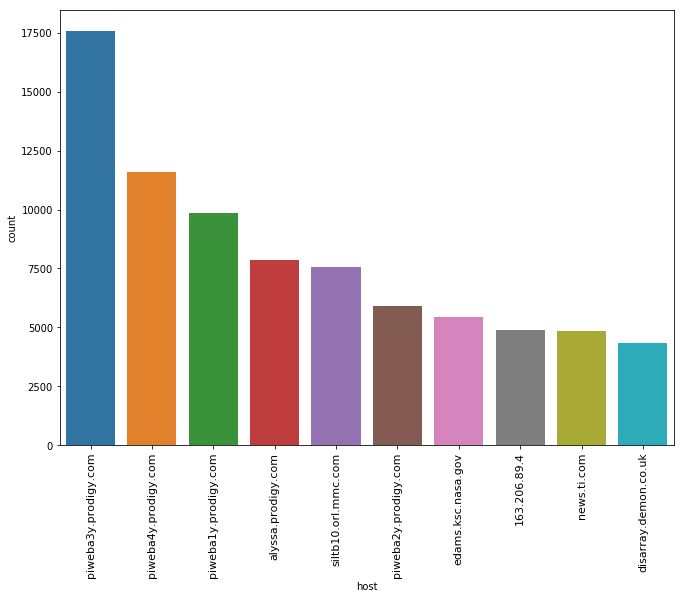

In [32]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
df=pd.DataFrame(result,columns=['host','count'])
plt.figure(figsize = (11,8))
sns.barplot(x='host',y='count',data=df)
# plt.subplots_adjust(bottom=0.6, right=0.8, top=0.9)
plt.xticks(rotation="vertical",fontsize=11)
plt.show()

#### Parse and map to hosts to groups

In [26]:
parsed_rdd = rdd.map(lambda line: parse_log2(line)).filter(lambda line: line[1] == 1).map(lambda line : line[0])
parsed_rdd2 = parsed_rdd.map(lambda line: map2groups(line))
rslt=(parsed_rdd2.map(lambda x:(x[5],1))
                 .reduceByKey(lambda a,b:a+b)
                 .takeOrdered(10, lambda x: -x[1]))
rslt

[('"GET /images/NASA-logosmall.gif HTTP/1.0"', 110679),
 ('"GET /images/KSC-logosmall.gif HTTP/1.0"', 89355),
 ('"GET /images/MOSAIC-logosmall.gif HTTP/1.0"', 59967),
 ('"GET /images/USA-logosmall.gif HTTP/1.0"', 59514),
 ('"GET /images/WORLD-logosmall.gif HTTP/1.0"', 58997),
 ('"GET /images/ksclogo-medium.gif HTTP/1.0"', 58411),
 ('"GET /images/launch-logo.gif HTTP/1.0"', 40780),
 ('"GET /shuttle/countdown/ HTTP/1.0"', 40132),
 ('"GET /ksc.html HTTP/1.0"', 39830),
 ('"GET /images/ksclogosmall.gif HTTP/1.0"', 33528)]

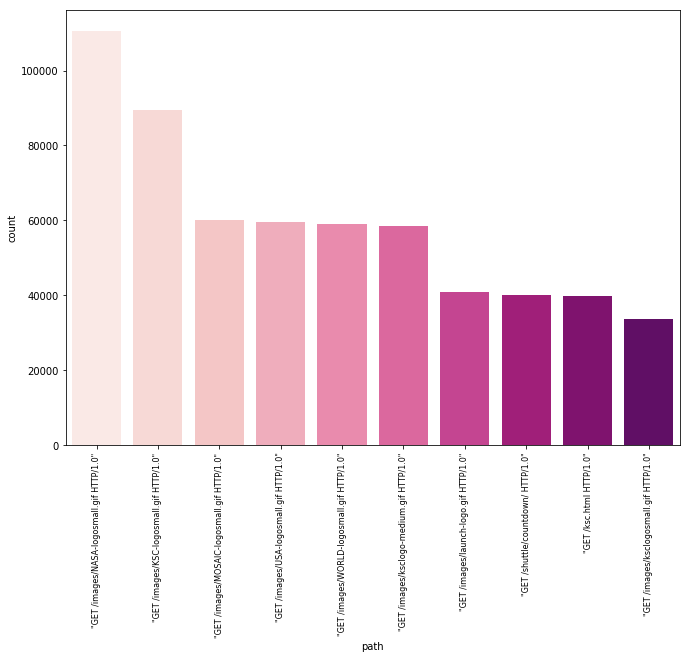

In [27]:
import seaborn as sns
df=pd.DataFrame(rslt,columns=['path','count'])
plt.figure(figsize = (11,8))
sns.barplot(x='path',y='count',data=df, palette = 'RdPu')
plt.xticks(rotation="vertical",fontsize=8)
display()

#### Compute counts of HTTP response status

In [28]:
parsed_rdd = rdd.map(lambda line: parse_log2(line)).filter(lambda line: line[1] == 1).map(lambda line : line[0])
parsed_rdd2 = parsed_rdd.map(lambda line: map2groups(line))
rslt=(parsed_rdd2.map(lambda x:(x[7],1))
                 .reduceByKey(lambda a,b:a+b)
                 .takeOrdered(10, lambda x: -x[1]))
rslt

[('200', 1698491),
 ('304', 132626),
 ('302', 46545),
 ('404', 10711),
 ('500', 62),
 ('403', 54),
 ('501', 14)]

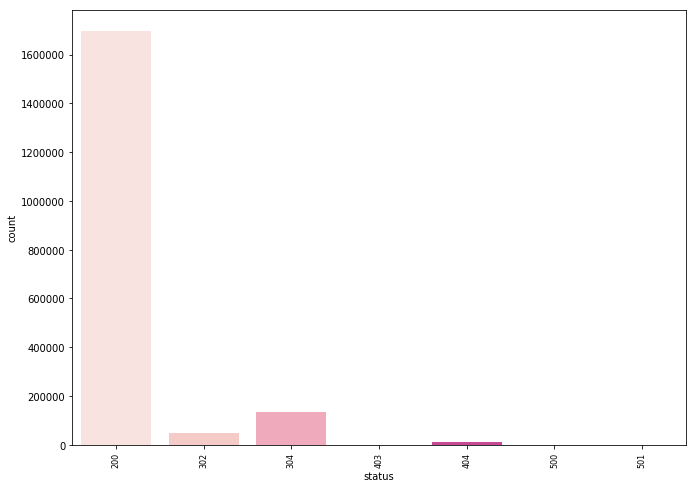

In [29]:
import seaborn as sns
df=pd.DataFrame(rslt,columns=['status','count'])
plt.figure(figsize = (11,8))
sns.barplot(x='status',y='count',data=df, palette = 'RdPu')
plt.xticks(rotation="vertical",fontsize=8)
display()

#### Compute content size

In [30]:
parsed_rdd = rdd.map(lambda line: parse_log2(line)).filter(lambda line: line[1] == 1).map(lambda line : line[0])
parsed_rdd2 = parsed_rdd.map(lambda line: map2groups(line))
rslt=(parsed_rdd2.map(lambda x:(x[8],1))
                 .reduceByKey(lambda a,b:a+b)
                 .takeOrdered(10, lambda x: -x[1]))
rslt

[('0', 139615),
 ('786', 89572),
 ('1204', 76805),
 ('363', 53275),
 ('234', 52861),
 ('5866', 52531),
 ('669', 52508),
 ('1713', 36099),
 ('3635', 30387),
 ('1173', 28960)]

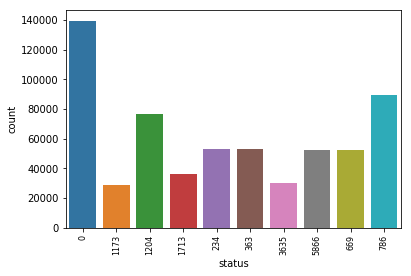

In [31]:
import seaborn as sns
df=pd.DataFrame(rslt,columns=['status','count'])
sns.barplot(x='status',y='count',data=df)
plt.xticks(rotation="vertical",fontsize=8)
plt.show()